In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

# Preprocessing Steps

1. Prepare dataset: add class to indicate if the piece is real or fake news

2. Tokenization to create a bag of words: remain only alphabetical lower case words

3. Lemmatization/Stemming: shorten words

4. Removing stopwords

## Prepare dataset

In [2]:
fake = pd.read_csv('Fake.csv')
real = pd.read_csv('True.csv')
fake['class'] = 1
real['class'] = 0
data = pd.concat([fake, real], axis=0).reset_index()

In [3]:
data.head(5)

,index,title,text,subject,date,class
0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


## Preprocessing

1. lowercase
2. remain only words, not numbers

In [4]:
data_text = data['text'].str.lower()

In [5]:
data_text = data_text.replace(to_replace ='[^a-zA-Z]', value = ' ', regex = True)

## Train Test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_text, data['class'], test_size=0.33, random_state=7406)

### Word Vectorization using count

1. Lemmatization included in CountVectorizer

In [7]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [8]:
#update stopwords
wnl = WordNetLemmatizer()
stop_words_lemma = [wnl.lemmatize(t) for t in stopwords.words('english')]
stop_words_lemma.extend(["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'])

In [9]:
# define stopwords
stop_words = ENGLISH_STOP_WORDS
# create CountVectorizer class
count_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), max_features=1000, stop_words = stop_words_lemma)
# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

In [10]:
count_df = pd.DataFrame(count_train.toarray(), columns=count_vectorizer.get_feature_names())

In [11]:
count_df.head(5)

,able,abortion,absolutely,access,according,account,accused,across,act,action,...,working,world,wrong,wrote,year,yes,yet,york,young,youtube
0,0,0,0,0,1,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,6,0,0,0,1,0,0,...,0,4,0,0,4,0,1,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Word Vectorization using Term Frequency - Inverse Document Frequency

In [12]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), max_features=1000, stop_words = stop_words_lemma)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [13]:
tfidf_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names())

In [14]:
tfidf_df.head(5)

,able,abortion,absolutely,access,according,account,accused,across,act,action,...,working,world,wrong,wrote,year,yes,yet,york,young,youtube
0,0.000000,0.0,0.0,0.000000,0.044588,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.194269,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.024103,0.0,0.000000,0.000000,0.0,0.056287
2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.213613,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
3,0.000000,0.0,0.0,0.346049,0.000000,0.0,0.0,0.049592,0.0,0.000000,...,0.0,0.161348,0.0,0.0,0.106989,0.0,0.046902,0.000000,0.0,0.000000
4,0.039529,0.0,0.0,0.000000,0.028672,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.034826,0.0,0.000000


#### check if the count vectorization returns same features as tfidf

In [15]:
# Calculate the difference in columns: difference
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)

set()


## Dimensionality Reduction

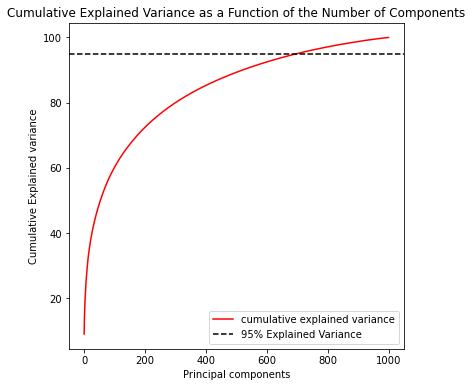

In [16]:
svd = TruncatedSVD(n_components=999)
svd.fit(count_train)
cumsum = np.cumsum(svd.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(6, 6))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')
plt.show()

In [18]:
svd_count = TruncatedSVD(n_components=700)
svd_count.fit(count_train)
transformed_count_train = svd_count.transform(count_train)
transformed_count_test = svd_count.transform(count_test)

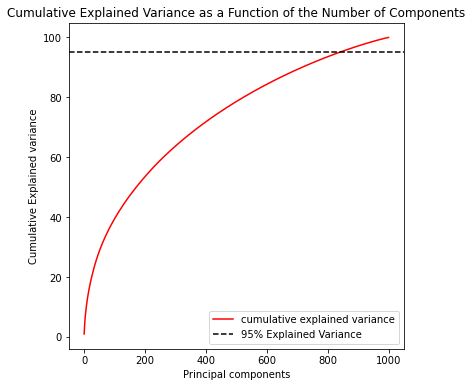

In [19]:
svd = TruncatedSVD(n_components=999)
svd.fit(tfidf_train)
cumsum = np.cumsum(svd.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(6, 6))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')
plt.show()

In [20]:
svd_tfidf = TruncatedSVD(n_components=850)
svd_tfidf.fit(tfidf_train)
transformed_tfidf_train = svd_tfidf.transform(tfidf_train)
transformed_tfidf_test = svd_tfidf.transform(tfidf_test)

## Classifiers on Count

**1. Logistic Regression: with parameter tuning on $C$ (penalty strength)**

In [21]:
lg_params = {'C': [100, 10, 1.0, 0.1, 0.01]}
lg = LogisticRegression(random_state =7406, max_iter=500, penalty='l2')
lg_gscv = GridSearchCV(lg, lg_params)
lg_gscv.fit(transformed_count_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=500, random_state=7406),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]})

In [22]:
pd.DataFrame(lg_gscv.cv_results_).round(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.15,0.36,0.01,0.0,100,{'C': 100},0.99,0.99,0.99,0.99,0.99,0.99,0.0,5
1,5.54,0.33,0.01,0.0,10,{'C': 10},0.99,0.99,0.99,0.99,0.99,0.99,0.0,4
2,3.26,0.10,0.01,0.0,1,{'C': 1.0},0.99,0.99,0.99,0.99,0.99,0.99,0.0,3
3,1.77,0.11,0.01,0.0,0.1,{'C': 0.1},0.99,0.99,0.99,0.99,0.99,0.99,0.0,1
4,1.07,0.03,0.01,0.0,0.01,{'C': 0.01},0.99,0.99,0.99,0.99,0.99,0.99,0.0,2


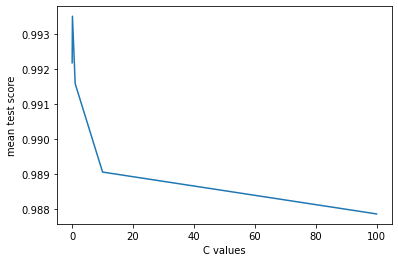

In [23]:
plt.plot([100, 10, 1.0, 0.1, 0.01], lg_gscv.cv_results_['mean_test_score'])
plt.xlabel('C values')
plt.ylabel('mean test score')
plt.show()

In [24]:
print("The optimal value of C after parameter tuning: ", lg_gscv.best_estimator_)

The optimal value of C after parameter tuning:  LogisticRegression(C=0.1, max_iter=500, random_state=7406)


---- Prediction ----

In [26]:
lg = LogisticRegression(random_state =7406, max_iter=500, penalty='l2', C=0.1)
lg.fit(transformed_count_train, y_train)
pred_lg_count = lg.predict(transformed_count_test)
lg_count_acc = accuracy_score(y_test, pred_lg_count)

In [27]:
print("The accuracy score of logistic regression model on counts: ", lg_count_acc)

The accuracy score of logistic regression model on counts:  0.9948032665181886


**2. Support Vector Machine**

In [28]:
svm_params = {'kernel': ['linear','rbf']}
svm = SVC(random_state=123)
svm_gscv = GridSearchCV(svm, svm_params)
svm_gscv.fit(transformed_count_train, y_train)

GridSearchCV(estimator=SVC(random_state=123),
             param_grid={'kernel': ['linear', 'rbf']})

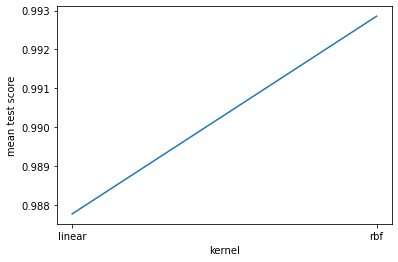

In [29]:
plt.plot(['linear', 'rbf'], svm_gscv.cv_results_['mean_test_score'])
plt.xlabel('kernel')
plt.ylabel('mean test score')
plt.show()

In [30]:
print("The optimal value of C after parameter tuning: ", svm_gscv.best_estimator_)

The optimal value of C after parameter tuning:  SVC(random_state=123)


---- Prediction ----

In [31]:
svm = SVC(random_state=123, kernel='rbf')
svm.fit(transformed_count_train, y_train)
pred_svm_count = svm.predict(transformed_count_test)
svm_count_acc = accuracy_score(y_test, pred_svm_count)

In [32]:
print("The accuracy score of support vector machine on counts: ", svm_count_acc)

The accuracy score of support vector machine on counts:  0.9937909158399136


**3. Random Forest**

In [33]:
rf_params = {'n_estimators': [10, 100, 500], \
             'max_features': ['auto', 'sqrt']}
rf = RandomForestClassifier(criterion='gini')
rf_gscv = GridSearchCV(rf, rf_params)
rf_gscv.fit(transformed_count_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'n_estimators': [10, 100, 500]})

In [37]:
print("The optimal value of C after parameter tuning: ", rf_gscv.best_params_)

The optimal value of C after parameter tuning:  {'max_features': 'auto', 'n_estimators': 500}


---- Prediction ----

In [39]:
rf = RandomForestClassifier(criterion='gini', n_estimators=500, max_features='auto')
rf.fit(transformed_count_train, y_train)
pred_rf_count = rf.predict(transformed_count_test)
rf_count_acc = accuracy_score(y_test, pred_rf_count)

In [40]:
print("The accuracy score of random forest on counts: ", rf_count_acc)

The accuracy score of random forest on counts:  0.9559290004724303


**4. K Nearest Neighbor**

In [41]:
knn_params = {'n_neighbors': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
knn = KNeighborsClassifier()
knn_gscv = GridSearchCV(knn, knn_params)
knn_gscv.fit(transformed_count_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                         100]})

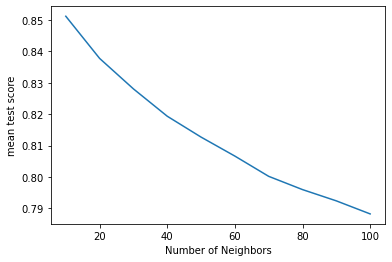

In [42]:
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], knn_gscv.cv_results_['mean_test_score'])
plt.xlabel('Number of Neighbors')
plt.ylabel('mean test score')
plt.show()

In [43]:
print("The optimal value of C after parameter tuning: ", knn_gscv.best_params_)

The optimal value of C after parameter tuning:  {'n_neighbors': 10}


---- Prediction ----

In [65]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(transformed_count_train, y_train)
pred_knn_count = knn.predict(transformed_count_test)
knn_count_acc = accuracy_score(y_test, pred_knn_count)

In [66]:
print("The accuracy score of k nearest neighbor on counts: ", knn_count_acc)

The accuracy score of k nearest neighbor on counts:  0.8532091516501316


## Classifiers on tfidf

**1. Logistic Regression**

In [44]:
lg_params = {'C': [100, 10, 1.0, 0.1, 0.01]}
lg = LogisticRegression(random_state =7406, max_iter=500, penalty='l2')
lg_gscv = GridSearchCV(lg, lg_params)
lg_gscv.fit(transformed_tfidf_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=500, random_state=7406),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]})

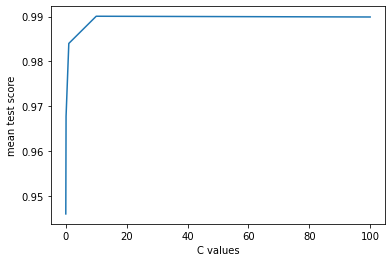

In [45]:
plt.plot([100, 10, 1.0, 0.1, 0.01], lg_gscv.cv_results_['mean_test_score'])
plt.xlabel('C values')
plt.ylabel('mean test score')
plt.show()

In [46]:
print("The optimal value of C after parameter tuning: ", lg_gscv.best_estimator_)

The optimal value of C after parameter tuning:  LogisticRegression(C=10, max_iter=500, random_state=7406)


In [63]:
lg = LogisticRegression(random_state =7406, max_iter=500, penalty='l2', C=10)
lg.fit(transformed_tfidf_train, y_train)
pred_lg_tfidf = lg.predict(transformed_tfidf_test)
lg_tfidf_acc = accuracy_score(y_test, pred_lg_tfidf)

In [64]:
print("The accuracy score of logistic regression on tfidf scores: ", lg_tfidf_acc)

The accuracy score of logistic regression on tfidf scores:  0.9884592022676655


**2. Support Vector Machine**

In [47]:
svm_params = {'kernel': ['linear','rbf']}
svm = SVC(random_state=123)
svm_gscv = GridSearchCV(svm, svm_params)
svm_gscv.fit(transformed_tfidf_train, y_train)

GridSearchCV(estimator=SVC(random_state=123),
             param_grid={'kernel': ['linear', 'rbf']})

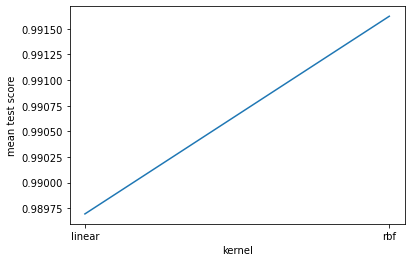

In [48]:
plt.plot(['linear', 'rbf'], svm_gscv.cv_results_['mean_test_score'])
plt.xlabel('kernel')
plt.ylabel('mean test score')
plt.show()

In [49]:
print("The optimal value of C after parameter tuning: ", svm_gscv.best_estimator_)

The optimal value of C after parameter tuning:  SVC(random_state=123)


---- Prediction ----

In [61]:
svm = SVC(random_state=123, kernel='rbf')
svm.fit(transformed_tfidf_train, y_train)
pred_svm_tfidf = svm.predict(transformed_tfidf_test)
svm_tfidf_acc = accuracy_score(y_test, pred_svm_tfidf)

In [62]:
print("The accuracy score of support vector machine on tfidf scores: ", svm_tfidf_acc)

The accuracy score of support vector machine on tfidf scores:  0.9906863737598705


**3. Random Forest**

In [50]:
rf_params = {'n_estimators': [10, 100, 500, 1000], \
             'max_features': ['auto', 'sqrt']}
rf = RandomForestClassifier(criterion='gini')
rf_gscv = GridSearchCV(rf, rf_params)
rf_gscv.fit(transformed_tfidf_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'n_estimators': [10, 100, 500, 1000]})

In [58]:
print("The optimal value of C after parameter tuning: ", rf_gscv.best_params_)

The optimal value of C after parameter tuning:  {'max_features': 'auto', 'n_estimators': 1000}


---- Prediction ----

In [59]:
rf = RandomForestClassifier(criterion='gini', n_estimators= 500, max_features='auto')
rf.fit(transformed_tfidf_train, y_train)
pred_rf_tfidf = rf.predict(transformed_tfidf_test)
rf_tfidf_acc = accuracy_score(y_test, pred_rf_tfidf)

In [60]:
print("The accuracy score of random forest on tfidf scores: ", rf_tfidf_acc)

The accuracy score of random forest on tfidf scores:  0.9569413511507052


**4. K Nearest Neighbor**

In [52]:
knn_params = {'n_neighbors': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
knn = KNeighborsClassifier()
knn_gscv = GridSearchCV(knn, knn_params)
knn_gscv.fit(transformed_tfidf_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                         100]})

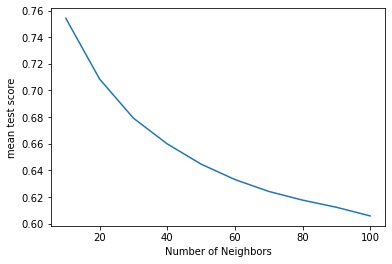

In [55]:
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], knn_gscv.cv_results_['mean_test_score'])
plt.xlabel('Number of Neighbors')
plt.ylabel('mean test score')
plt.show()

---- Prediction ----

In [56]:
knn = KNeighborsClassifier(n_neighbors= 10)
knn.fit(transformed_tfidf_train, y_train)
pred_knn_tfidf = knn.predict(transformed_tfidf_test)
knn_tfidf_acc = accuracy_score(y_test, pred_knn_tfidf)

In [57]:
print("The accuracy score of k nearest neighbor on tfidf scores: ", knn_tfidf_acc)

The accuracy score of k nearest neighbor on tfidf scores:  0.755011135857461


## Model Comparison

In [67]:
model_compare = pd.DataFrame([[lg_count_acc, svm_count_acc, rf_count_acc, knn_count_acc], \
                              [lg_tfidf_acc, svm_tfidf_acc, rf_tfidf_acc, knn_tfidf_acc]],\
                              columns=['Logistic Regression', 'SVM', 'Random Forest', 'K Nearest Neighbor'], \
                              index = ['count', 'tfidf'])
model_compare

,Logistic Regression,SVM,Random Forest,K Nearest Neighbor
count,0.994803,0.993791,0.955929,0.853209
tfidf,0.988459,0.990686,0.956941,0.755011
